In [1]:
import time
import torch
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchtext.data import to_map_style_dataset

from reviews_dataset import reviews
from trainer import Trainer
import os
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
def train(trainer: Trainer, train_dataloader: DataLoader, valid_dataloader: DataLoader, EPOCHS = 10, LR = 5, BATCH_SIZE = 64):
    total_accu = None
    for epoch in range(1, EPOCHS + 1):
        epoch_start_time = time.time()
        trainer.train(train_dataloader, epoch)
        accu_val = trainer.evaluate(valid_dataloader)
        if total_accu is not None and total_accu > accu_val:
            trainer.scheduler.step()
        else:
            total_accu = accu_val
        print('-' * 59)
        print('| end of epoch {:3d} | time: {:5.2f}s | '
              'valid accuracy {:8.3f} '.format(epoch,
                                               time.time() - epoch_start_time,
                                               accu_val))
        print('-' * 59)

def predict(trainer, dataloader: DataLoader):
    trainer.model.eval()
    preds = np.array([])
    labels = np.array([])

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = trainer.model(text, offsets)
            preds = np.concatenate([preds, (predicted_label.argmax(1) == label).cpu().numpy()])
            labels = np.concatenate([labels, label.cpu().numpy()])
    return preds, labels

def evaluate(trainer, dataloader):
    preds, y_test = predict(trainer, dataloader)
    accuracy = accuracy_score(preds, y_test)
    recall = recall_score(preds, y_test, average=None)
    cm = confusion_matrix(preds, y_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neg','neu','pos'])
    f1 = f1_score(preds, y_test, average=None)
    disp.plot()

    return pd.DataFrame({'dataset':[dataset], 'accuracy':[np.round(accuracy, 3)], 'recall':[np.round(recall, 3)], 'f1_score':[np.round(f1,3)], 'training samples':[len(train_dataloader.dataset)]})

# def getDatasets(dataset_path, BATCH_SIZE, trainer):
#     dataset_iter = reviews(root=dataset_path)
#     dataset = to_map_style_dataset(dataset_iter)
#     num_train = int(len(dataset) * 0.8)
#     split_train_, split_test_ = random_split(dataset, [num_train, len(dataset) - num_train])

#     train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
#                                     shuffle=True, collate_fn=trainer.collate_batch)
#     test_dataloader = DataLoader(split_test_, batch_size=BATCH_SIZE,
#                                     shuffle=True, collate_fn=trainer.collate_batch)
#     return train_dataloader, test_dataloader

def getDatasets(dataset_path, BATCH_SIZE, trainer):
    train_iter, test_iter = reviews(root=dataset_path)
    train_dataset = to_map_style_dataset(train_iter)
    test_dataset = to_map_style_dataset(test_iter)
    num_train = int(len(train_dataset) * 0.95)
    split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

    train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                                    shuffle=True, collate_fn=trainer.collate_batch)
    valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                                    shuffle=True, collate_fn=trainer.collate_batch)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                    shuffle=True, collate_fn=trainer.collate_batch)
    return train_dataloader, valid_dataloader, test_dataloader


In [48]:
from typing import Union, Tuple

from torch.utils.data import functional_datapipe, IterDataPipe
from torchtext.data.datasets_utils import _wrap_split_argument
from torchdata.datapipes.iter import IterableWrapper, FileOpener

@_wrap_split_argument(("train"))
def reviews(root: str, split: Union[Tuple[str], str]):
    dp = IterableWrapper([root])
    dp = FileOpener(dp, mode='b')
    dp = dp.parse_json_files()
    return dp

a = reviews(root=dataset_path)

In [49]:
a

JsonParserIterDataPipe

In [46]:
BATCH_SIZE = 128
dataset_iter = FileOpener(IterableWrapper([dataset_path]), mode='b').parse_json_files().shuffle().set_shuffle(False).sharding_filter()
dataset = to_map_style_dataset(dataset_iter)
num_train = int(len(dataset) * 0.8)
split_train_, split_test_ = random_split(dataset, [num_train, len(dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                                shuffle=True, collate_fn=trainer.collate_batch)
test_dataloader = DataLoader(split_test_, batch_size=BATCH_SIZE,
                                shuffle=True, collate_fn=trainer.collate_batch)

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [43]:
len(dataset)

1

In [6]:
datasets = os.listdir("../FinalDatasets/")

FileNotFoundError: [WinError 3] System nie może odnaleźć określonej ścieżki: '../FinalDatasets/'

In [22]:
nothing, dataset_iter = reviews(root=dataset_path)
dataset = to_map_style_dataset(dataset_iter)

In [23]:
dataset

<torchtext.data.functional.to_map_style_dataset.<locals>._MapStyleDataset at 0x15934ae61f0>

In [25]:
ptm = pd.read_json("FinalDatasets/complete_dataset_ptm.json")

<AxesSubplot:>

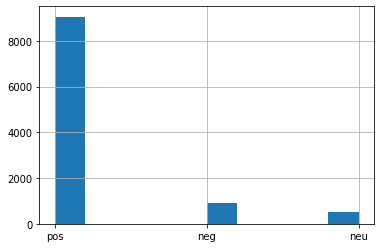

In [27]:
ptm['label'].hist()

In [31]:
torch.tensor(ptm['label'].values, dtype=)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [30]:
TensorDataset(ptm['label'].values)

TypeError: 'int' object is not callable

In [ ]:
a = DataLoader(ptm)

In [3]:
# Hyperparameters
EPOCHS = 10  # epoch
LR = 5  # learning rate
BATCH_SIZE = 64  # batch size for training

dataset_path = 'FinalDatasets/complete_dataset_ptm.json'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = reviews(root=dataset_path, split='train')

trainer = Trainer(dataset, device, LR)
# train_dataloader, test_dataloader = getDatasets(dataset_path, BATCH_SIZE, trainer)
train_dataloader, valid_dataloader, test_dataloader = getDatasets(dataset_path, BATCH_SIZE, trainer)
train(trainer, train_dataloader, test_dataloader)


# train(trainer, dataset_path)

# reviews_labels = {1: "Negative",
#                     2: "Neutral",
#                     3: "Positive"}

# ex_text_str1 = "Super mega proszek, bardzo dobry"
# ex_text_str2 = "Totalny badziew szkoda pieniędzy, beznadziejny, porażka"
# ex_text_str3 = "Nie domywa ale ładnie pachnie. Zostają smugi"
# ex_text_str4 = "Nie rozpuszczają się, dobrze domywają, ładnie pachną, ale bardzo drogie"

# print("This is a %s review" % reviews_labels[trainer.predict(ex_text_str1)])
# print("This is a %s review" % reviews_labels[trainer.predict(ex_text_str2)])
# print("This is a %s review" % reviews_labels[trainer.predict(ex_text_str3)])
# print("This is a %s review" % reviews_labels[trainer.predict(ex_text_str4)])


-----------------------------------------------------------
| end of epoch   1 | time:  3.01s | valid accuracy    0.868 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   2 | time:  0.96s | valid accuracy    0.879 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   3 | time:  0.90s | valid accuracy    0.888 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   4 | time:  1.04s | valid accuracy    0.882 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   5 | time:  1.05s | valid accuracy    0.894 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   6 | time:  1.06s |

In [4]:
preds, labels = predict(trainer, test_dataloader)

(array([ 227.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1869.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

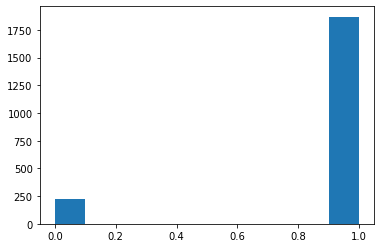

In [5]:
plt.hist(preds)

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,dataset,accuracy,recall,f1_score,training samples
0,ShardingFilterIterDataPipe,0.035,"[0.312, 0.005, 0.0]","[0.354, 0.009, 0.0]",8380


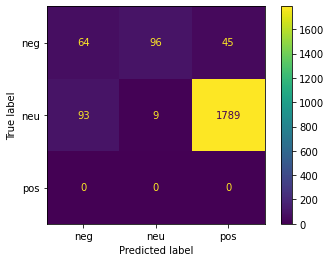

In [15]:
evaluate(trainer, test_dataloader)